In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
!pip install wordcloud
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pickle
from google.colab import drive

# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
data1 = pd.read_csv('gdrive/My Drive/Dissertation/cyberbullying_tweets.csv')

data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
data2 = pd.DataFrame(data)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data1.sample(5)

,tweet_text,cyberbullying_type
46558,@ItsTheCons STOP THE WORLD HIPHOP IS GAY AS FU...,ethnicity
29281,Not sure if I should be irritated by street ca...,other_cyberbullying
32884,Baby Shower of the girl who bullied you in hig...,age
1758,Our pancakes are selling like hotcakes Shaz - ...,not_cyberbullying
45613,RT @jden1120: RT @LEXXAthePinUp: @jden1120 lil...,ethnicity


In [ ]:
data2.sample(5)

,text,label
6099,if u were guna have a baby what wud u be looki...,0
11571,how many questions are in your inbox ? 5 now,0
5781,how long have you lived in australia ? since 9...,0
9321,is your middle name as cool as carla is ? carl...,0
1486,how many boyfriends have you had ? 3,0


In [ ]:
data1 = data1.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'target'})

In [ ]:
#check shape of the dataframes
print(data1.target.value_counts())
print(data2.label.value_counts())

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: target, dtype: int64
0    11997
1      776
Name: label, dtype: int64


In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
data1["No_of_Characters"] = data1["text"].apply(len)
data1["No_of_Words"]=data1.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data1["No_of_sentence"]=data1.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,47692.0,136.253229,85.226899,1.0,78.0,124.0,180.0,5018.0
No_of_Words,47692.0,28.775539,18.003309,1.0,17.0,25.0,38.0,1021.0
No_of_sentence,47692.0,2.038078,1.381094,1.0,1.0,2.0,3.0,66.0


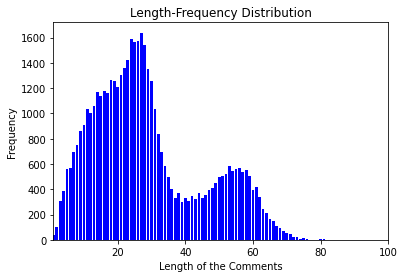

Maximum Length of a Comment: 1021
Minimum Length of a Comment: 1
Average Length of a Comment: 29.0


In [ ]:
frequency = dict()
for i in data1.No_of_Words:
  frequency[i] = frequency.get(i, 0)+1
plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 100)
plt.xlabel('Length of the Comments')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
max_length = max(data1.No_of_Words)
print(f"Maximum Length of a Comment: {max_length}")
print(f"Minimum Length of a Comment: {min(data1.No_of_Words)}")
print(f"Average Length of a Comment: {round(np.mean(data1.No_of_Words),0)}")

In [ ]:
#Removing outliers - sentence with less than 3 words or more than 100 words
data1 = data1[data1['No_of_Words'] > 3]
data1 = data1[data1['No_of_Words'] < 100]

In [ ]:
tmp = ['gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']
data1['label'] = data1['target'].apply(lambda x: 1 if x in tmp else 0)

data1['target'].value_counts()

religion               7996
age                    7982
ethnicity              7950
gender                 7918
not_cyberbullying      7808
other_cyberbullying    7572
Name: target, dtype: int64

In [ ]:
data2['label'].value_counts()

0    11997
1      776
Name: label, dtype: int64

In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
data2["No_of_Characters"] = data2["text"].apply(len)
data2["No_of_Words"]=data2.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data2["No_of_sentence"]=data2.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
label,12773.0,0.060753,0.238886,0.0,0.0,0.0,0.0,1.0
No_of_Characters,12773.0,117.250920,127.701501,0.0,52.0,86.0,146.0,5371.0
No_of_Words,12773.0,25.418931,26.966479,0.0,12.0,19.0,32.0,1102.0
No_of_sentence,12773.0,2.257105,1.638235,0.0,2.0,2.0,3.0,71.0


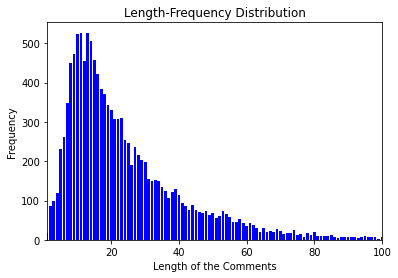

Maximum Length of a Comment: 1102
Minimum Length of a Comment: 0
Average Length of a Comment: 25.0


In [ ]:
frequency = dict()
for i in data2.No_of_Words:
  frequency[i] = frequency.get(i, 0)+1
plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 100)
plt.xlabel('Length of the Comments')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
max_length = max(data2.No_of_Words)
print(f"Maximum Length of a Comment: {max_length}")
print(f"Minimum Length of a Comment: {min(data2.No_of_Words)}")
print(f"Average Length of a Comment: {round(np.mean(data2.No_of_Words),0)}")

In [ ]:
#Removing outliers - sentence with less than 3 words or more than 100 words
data2 = data2[data2['No_of_Words'] > 2]
data2 = data2[data2['No_of_Words'] < 100]

In [ ]:
data1.label.value_counts()

1    39418
0     7808
Name: label, dtype: int64

In [ ]:
data2.label.value_counts()

0    11735
1      767
Name: label, dtype: int64

Now lets merge the datasets together minding the class balance.

0 => 7808 (tweets) + 11735(formspring) = 19543

1 => 39418+767 = 40185

Lets extract equal number (3840) of datapoints from each category to make the positive approzimately same as negative



In [ ]:
g = data1[data1['target']=='gender'].head(3760)
r = data1[data1['target']=='religion'].head(3760)
o = data1[data1['target']=='other_cyberbullying'].head(3760)
a = data1[data1['target']=='age'].head(3760)
e = data1[data1['target']=='ethnicity'].head(3760)
non = data1[data1['target'] == 'not_cyberbullying']
df1 = pd.concat([g,r,o,a,e,non], ignore_index=True)
df1 = df1.drop(columns='target')

In [ ]:
data2.head(2)

,text,label,No_of_Characters,No_of_Words,No_of_sentence
0,what is your favorite song ? d i like too many...,0,71,16,2
1,3 3 ? haha jk ! 33,0,18,7,3


In [ ]:
df1.head(2)

,text,No_of_Characters,No_of_Words,No_of_sentence,label
0,rape is real..zvasiyana nema jokes about being...,159,32,1,1
1,You never saw any celebrity say anything like ...,136,28,1,1


In [ ]:
df = pd.concat([df1,data2],ignore_index=True)

In [ ]:
df.label.value_counts()

1    19567
0    19543
Name: label, dtype: int64

In [ ]:
df.to_csv('gdrive/My Drive/Dissertation/enriched_owndata.csv')

Now we have created our own balanced dataset (combination of all kind of cyberbullying + tweets and formspring)

## Exploratory data analysis

In [ ]:
df.head()

,text,No_of_Characters,No_of_Words,No_of_sentence,label
0,rape is real..zvasiyana nema jokes about being...,159,32,1,1
1,You never saw any celebrity say anything like ...,136,28,1,1
2,"@ManhattaKnight I mean he's gay, but he uses g...",80,17,1,1
3,RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...,66,11,1,1
4,Rape is rape. And the fact that I read one pos...,273,63,4,1


Text(0, 0.5, 'Number of Data points')

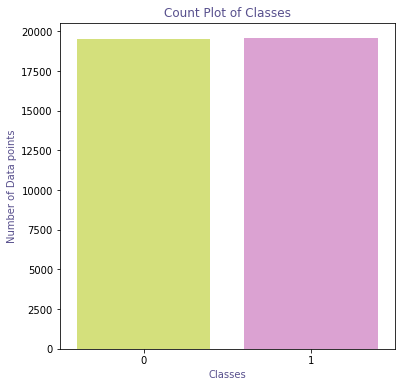

In [ ]:
#Palette
cols= ["#E1F16B", "#E598D8"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(6,6))
fg = sns.countplot(x= df["label"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [ ]:
df.isna().sum()

text                0
No_of_Characters    0
No_of_Words         0
No_of_sentence      0
label               0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39110.0,122.275812,76.577300,5.0,64.0,107.0,144.0,910.0
No_of_Words,39110.0,26.059294,16.105006,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39110.0,2.057402,1.268219,1.0,1.0,2.0,3.0,30.0
label,39110.0,0.500307,0.500006,0.0,0.0,1.0,1.0,1.0


In [ ]:
df.text.head(10)

0    rape is real..zvasiyana nema jokes about being...
1    You never saw any celebrity say anything like ...
2    @ManhattaKnight I mean he's gay, but he uses g...
3    RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...
4    Rape is rape. And the fact that I read one pos...
5    @coiny Also, it's hard to take a company serio...
6    Idgaf if you are gay, lesbian, bisexual, or wh...
7    #GermanProfessor gives meaning to term FemiNaz...
8    RT @mcclure111: #DontDateSJWs #ThatWouldBeAVio...
9    So I call you female I’m basically calling you...
Name: text, dtype: object

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if g(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def elongated_support(sent):
  tmp = []
  for word in str.split(sent):
    tmp.append(replaceElongated(word))
  return ' '.join(tmp)

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r" wanna", " want to", text)
    text = re.sub(r" gonna", " going to", text)
    text = re.sub(r" ppl", " people", text)
    text = re.sub(r" u ?r", " you are", text)
    text = re.sub(r" ?cant", " can not", text)
    text = re.sub(r" ?wont", " will not", text)
    text = re.sub(r" outta", " out of", text)
    text = re.sub(r" ?yu ", " you ", text)
    text = re.sub(r" ?yurself", " yourself ", text)
    text = re.sub(r" ?urself", " yourself", text)
    text = re.sub(r" wat ", " what ", text)
    text = re.sub(r" ?wen ", " when ", text)
    text = re.sub(r" y ", " why ", text)
    text = re.sub(r" ?pls ", " please ", text)
    text = re.sub(r" ain\'t ", " is not ", text)
    text = re.sub(r" \& ", " and ", text)
    return text

In [ ]:
elongated_support("thisss youuu")

'this you'

In [ ]:
import string
def cleancomments(text):
    text = re.sub('\(created.at:\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d\)', ' ', str(text)) #replacing comment time
    text = re.sub('<font color\=\"\#0066CC\"\>.*?\<\/font>', ' ', str(text)) # removing html tags with username
    text = re.sub('@[^\s]+', ' ', str(text)) #removing user tag
    #Remove unicode strings like "\u002c" and "x96"
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text) 
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    #removing url
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    #temp2 = re.sub(r'#([^\s]+)', r' ', text) # removing hashtags
    #removing emoticons
    text = re.sub(':\)|;\)|:-\)|<3|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', ' ', text)
    text = ''.join([i for i in text if not i.isdigit()])
    #temp6 = re.sub(r"(\.)\1+", '.', temp5)
    #temp7 = re.sub(r"( \.)+", '.', temp6)
    #temp8 = re.sub(r"(\!)\1+", ' multiexclamation', temp7)
    #temp9 = re.sub(r"(\_)+", '', temp8)
    text = ' '.join( [w for w in text.split() if len(w)>1]) #removing single characters
    text = re.sub(' +', ' ', text) #removing additional whitespaces
    text = str.lower(text)
    return text
def removepunct(txt):
  remove = string.punctuation
  #remove = remove.replace("#", "") # don't remove hash
  pattern = r"[{}]".format(remove) # create the pattern
  text = re.sub(pattern, " ", txt)
  text = re.sub(' +', ' ', text) #remove additional whitespaces
  return text

def remove_filteredwords(tweet):
    text = " ".join([word for word in tweet.split() if word not in ['rt','amp', 'mkr', 'bc', 'ta', 'el', 'lt', 'im', 've', 'ur', 'co', 'kat', 'de', 'andre', 'http', 'https', 'www', 'gt', 'gon', 'na', 'wan', 'ly', 'di', 'tumblr', 'com']])
    return text

In [ ]:
df['clean_text'] = df['text'].apply(lambda x: elongated_support(x))
df['clean_text'] = df['clean_text'].apply(lambda x: decontract(x))
df['clean_text'] = df['clean_text'].apply(lambda x: cleancomments(x))
df['clean_text'] = df['clean_text'].apply(lambda z: removepunct(z))

In [ ]:
df['clean_text'] = df['clean_text'].apply(lambda z: remove_filteredwords(z))

In [ ]:
df[['text', 'clean_text']].head(10)

,text,clean_text
0,rape is real..zvasiyana nema jokes about being...,rape is real zvasiyana nema jokes about being ...
1,You never saw any celebrity say anything like ...,you never saw any celebrity say anything like ...
2,"@ManhattaKnight I mean he's gay, but he uses g...",mean he is gay but he uses gendered slurs and ...
3,RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...,feminazi
4,Rape is rape. And the fact that I read one pos...,rape is rape and the fact that read one post a...
5,"@coiny Also, it's hard to take a company serio...",also it is hard to take company seriously re h...
6,"Idgaf if you are gay, lesbian, bisexual, or wh...",idgaf if you are gay lesbian bisexual or whate...
7,#GermanProfessor gives meaning to term FemiNaz...,germanprofesor gives meaning to term feminazi ...
8,RT @mcclure111: #DontDateSJWs #ThatWouldBeAVio...,dontdatesjws thatwouldbeaviolationoftherestrai...
9,So I call you female I’m basically calling you...,so call you female basically calling you bitch


In [ ]:
df.isna().sum()

text                0
No_of_Characters    0
No_of_Words         0
No_of_sentence      0
label               0
clean_text          0
dtype: int64

In [ ]:
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["clean_text"]), axis=1)
 
print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*df["Tokenize_Text"][:10], sep = "\n")

 The First 5 Texts after Tokenizing:
['rape', 'is', 'real', 'zvasiyana', 'nema', 'jokes', 'about', 'being', 'drunk', 'or', 'being', 'gay', 'or', 'being', 'lesbian', 'rape', 'is', 'not', 'ones', 'choice', 'or', 'wish', 'thtz', 'where', 'the', 'sensitivity', 'is', 'coming', 'from']
['you', 'never', 'saw', 'any', 'celebrity', 'say', 'anything', 'like', 'this', 'for', 'obama', 'maher', 'incest', 'rape', 'joke', 'colbert', 'gay', 'joke', 'griffin', 'beheading', 'joke']
['mean', 'he', 'is', 'gay', 'but', 'he', 'uses', 'gendered', 'slurs', 'and', 'makes', 'rape', 'jokes']
['feminazi']
['rape', 'is', 'rape', 'and', 'the', 'fact', 'that', 'read', 'one', 'post', 'about', 'guy', 'getting', 'raped', 'and', 'the', 'comments', 'are', 'calling', 'him', 'gay', 'and', 'he', 'should', 'be', 'hapy', 'stfu', 'and', 'really', 'hope', 'no', 'one', 'takes', 'this', 'as', 'joke', 'tf', 'you', 'own', 'no', 'ones', 'body', 'you', 'have', 'no', 'rights', 'to', 'do', 'whatever', 'you', 'want', 'to', 'someone', 'e

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df["Lemmatized_Text"] = df["Tokenize_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*df["Lemmatized_Text"][:10], sep = "\n")

 The First 5 Texts after lemitization:
['rape', 'be', 'real', 'zvasiyana', 'nema', 'joke', 'about', 'be', 'drink', 'or', 'be', 'gay', 'or', 'be', 'lesbian', 'rape', 'be', 'not', 'ones', 'choice', 'or', 'wish', 'thtz', 'where', 'the', 'sensitivity', 'be', 'come', 'from']
['you', 'never', 'saw', 'any', 'celebrity', 'say', 'anything', 'like', 'this', 'for', 'obama', 'maher', 'incest', 'rape', 'joke', 'colbert', 'gay', 'joke', 'griffin', 'behead', 'joke']
['mean', 'he', 'be', 'gay', 'but', 'he', 'use', 'gendered', 'slur', 'and', 'make', 'rape', 'joke']
['feminazi']
['rape', 'be', 'rape', 'and', 'the', 'fact', 'that', 'read', 'one', 'post', 'about', 'guy', 'get', 'rap', 'and', 'the', 'comment', 'be', 'call', 'him', 'gay', 'and', 'he', 'should', 'be', 'hapy', 'stfu', 'and', 'really', 'hope', 'no', 'one', 'take', 'this', 'as', 'joke', 'tf', 'you', 'own', 'no', 'ones', 'body', 'you', 'have', 'no', 'right', 'to', 'do', 'whatever', 'you', 'want', 'to', 'someone', 'else']
['also', 'it', 'be', 'ha

In [ ]:
df['X'] = df["Lemmatized_Text"].apply(lambda x: ' '.join([row for row in x]))

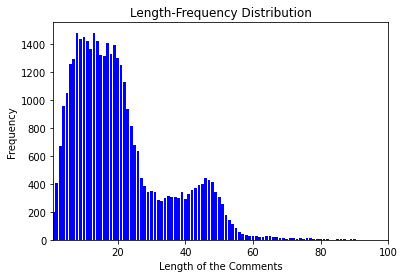

Maximum Length of a Comment: 93
Minimum Length of a Comment: 0
Average Length of a Comment: 21.0


In [ ]:
#Finding the max_length
df['sent_length'] = df['Lemmatized_Text'].apply(lambda x: len(x))
frequency = dict()
for i in df.sent_length:
  frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 100)
plt.xlabel('Length of the Comments')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
max_length = max(df.sent_length)
print(f"Maximum Length of a Comment: {max_length}")
print(f"Minimum Length of a Comment: {min(df.sent_length)}")
print(f"Average Length of a Comment: {round(np.mean(df.sent_length),0)}")

In [ ]:
len(df[df['sent_length']==0])

31

In [ ]:
df[df['sent_length']==0]

,text,No_of_Characters,No_of_Words,No_of_sentence,label,clean_text,Tokenize_Text,Lemmatized_Text,X,sent_length
2689,@ZombieNeith @GRIMACHU,22,4,1,1,,[],[],,0
7543,@JillWetzler I ❤️ u,19,5,1,1,,[],[],,0
7619,@nigel_kerr &lt;3,17,6,1,1,,[],[],,0
7711,?????????,9,9,2,1,,[],[],,0
7872,RT @desertfox899: @freebsdgirl,30,6,1,1,,[],[],,0
8125,ââââ»âââââ»âââ,36,5,1,1,,[],[],,0
9357,#MKR #MKR2015,13,4,1,1,,[],[],,0
9399,@Ooooh_NaNa @_lovejade,22,4,1,1,,[],[],,0
9472,@orcrist86 @Spacekatgal ;),26,6,1,1,,[],[],,0
9851,@samusclone &lt;3,17,6,1,1,,[],[],,0


In [ ]:
df = df[df['sent_length']!=0] #removing rows with 0 words

In [ ]:
df.label.value_counts()

1    19553
0    19526
Name: label, dtype: int64

In [ ]:
df.to_csv('gdrive/My Drive/Dissertation/enriched_processed_form+tweet.csv')

In [ ]:
from google.colab import drive

# Connect to google drive
drive.mount('/content/gdrive')

import pandas as pd
df = pd.read_csv('gdrive/My Drive/Dissertation/enriched_processed_form+tweet.csv', index_col=0)

Mounted at /content/gdrive


In [ ]:
df['text'].sample(5)

4398     What does being a Muslim have to do with any o...
11672    Y’all think high school bullying is bad ? Try ...
31312    i happen to think your very pretty thanks your...
34002    33333r i have to tell you stuff tomorrow bbygr...
28815    what is the first job you had ? babaysitting a...
Name: text, dtype: object

In [ ]:
df.sample(10)

,text,No_of_Characters,No_of_Words,No_of_sentence,label,clean_text,Tokenize_Text,Lemmatized_Text,X,sent_length
12962,The cops don't like a fair fight. They like to...,193,43,3,1,the cops do not like fair fight they like to f...,"['the', 'cops', 'do', 'not', 'like', 'fair', '...","['the', 'cop', 'do', 'not', 'like', 'fair', 'f...",the cop do not like fair fight they like to fi...,35
9074,Thank you everyone that pointed out it's from ...,105,23,2,1,thank you everyone that pointed out it is from...,"['thank', 'you', 'everyone', 'that', 'pointed'...","['thank', 'you', 'everyone', 'that', 'point', ...",thank you everyone that point out it be from t...,21
34003,dating i would say my ex which one ? i will no...,111,30,2,0,dating would say my ex which one will not say ...,"['dating', 'would', 'say', 'my', 'ex', 'which'...","['date', 'would', 'say', 'my', 'ex', 'which', ...",date would say my ex which one will not say do...,21
33419,what is your favorite song when you are in the...,181,41,3,0,what is your favorite song when you are in the...,"['what', 'is', 'your', 'favorite', 'song', 'wh...","['what', 'be', 'your', 'favorite', 'song', 'wh...",what be your favorite song when you be in the ...,31
5698,So what r u if we r bhakts? Touts? Do some sel...,267,57,6,1,so what if we bhakts touts do some self realiz...,"['so', 'what', 'if', 'we', 'bhakts', 'touts', ...","['so', 'what', 'if', 'we', 'bhakts', 'tout', '...",so what if we bhakts tout do some self realiza...,43
16499,y’all niggers dumb as fuck &amp; y’all daddies...,77,21,1,1,al niggers dumb as fuck al dadies uncles and g...,"['al', 'niggers', 'dumb', 'as', 'fuck', 'al', ...","['al', 'niggers', 'dumb', 'as', 'fuck', 'al', ...",al niggers dumb as fuck al dadies uncles and g...,12
35207,do you like pickles ? no lol you mean dill pic...,135,29,4,0,do you like pickles no lol you mean dill pickl...,"['do', 'you', 'like', 'pickles', 'no', 'lol', ...","['do', 'you', 'like', 'pickle', 'no', 'lol', '...",do you like pickle no lol you mean dill pickle...,26
19480,"@ShavaneBandoo mi either, but them claim seh t...",101,21,1,0,mi either but them claim seh they do not want ...,"['mi', 'either', 'but', 'them', 'claim', 'seh'...","['mi', 'either', 'but', 'them', 'claim', 'seh'...",mi either but them claim seh they do not want ...,17
7290,I'm sorry you had to go through this. The way ...,262,53,5,1,am sorry you had to go through this the way th...,"['am', 'sorry', 'you', 'had', 'to', 'go', 'thr...","['be', 'sorry', 'you', 'have', 'to', 'go', 'th...",be sorry you have to go through this the way t...,46
37957,how old is your daughter ? 16,29,7,2,0,how old is your daughter,"['how', 'old', 'is', 'your', 'daughter']","['how', 'old', 'be', 'your', 'daughter']",how old be your daughter,5


In [ ]:
df.text[5698]

'So what r u if we r bhakts? Touts? Do some self realization. See around u, how many countries hv bn d victims of through Islamic terrorism? How many Muslims hv respect for odr faiths compared 2 ppl like u guys calling odrs as kafirs. Ur acts r simply inhuman barbaric'

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.corpus import stopwords
from collections import defaultdict
from plotly import tools
from plotly.offline import iplot
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
#mask = np.array(Image.open("gdrive/My Drive/Dissertation/hand_mask.jpg"))

In [ ]:
def wc(label, title):
  terms = ' '.join(list(df[df['label'] == label]['X']))
  wcl = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(terms)
  plt.figure(figsize = (10, 8), facecolor = 'k')
  plt.imshow(wcl)
  plt.axis('off')
  plt.title(title, fontsize =25)
  plt.tight_layout(pad = 0)
  plt.show()

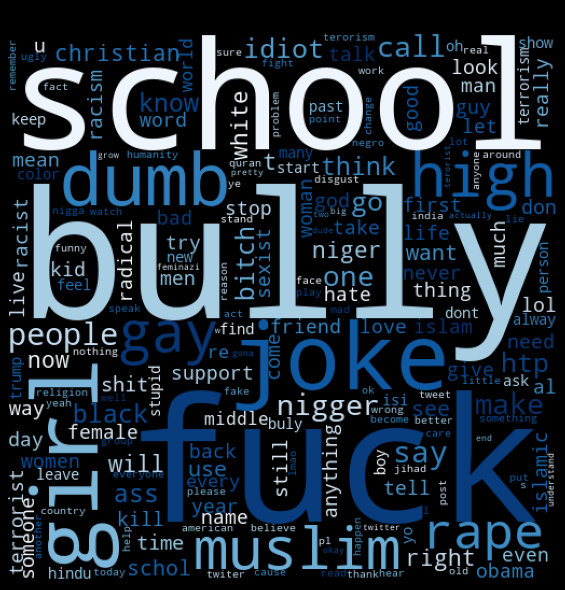

In [ ]:
wc(1, 'Cyberbullying')

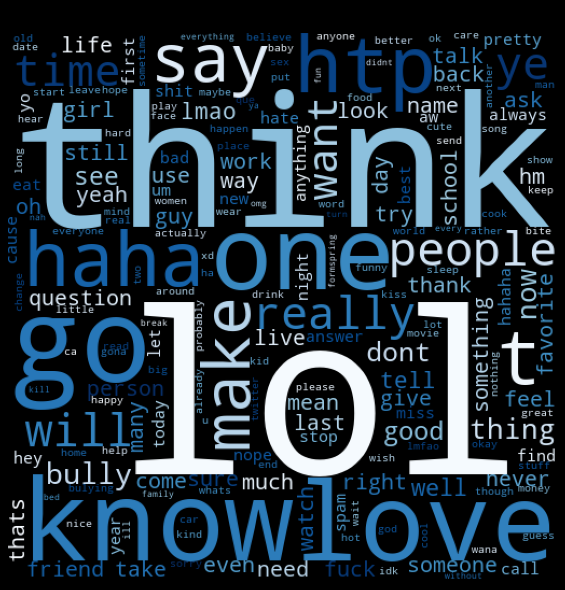

In [ ]:
wc(0, 'non-bullying')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import plotly.graph_objects as go
stop_words = set(stopwords.words("english"))

#Filtering data
pos = df[df["label"]==1].dropna()
neg = df[df["label"]==0].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in pos["X"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in neg["X"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words in bullying posts", "Frequent words in non-bullying posts"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)

fig['layout'].update(height=1000, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.8/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in pos["X"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in neg["X"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'brown')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Bullying class", 
                                          "Bigram plots of Non-bullying class"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)

fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

<Figure size 864x576 with 0 Axes>

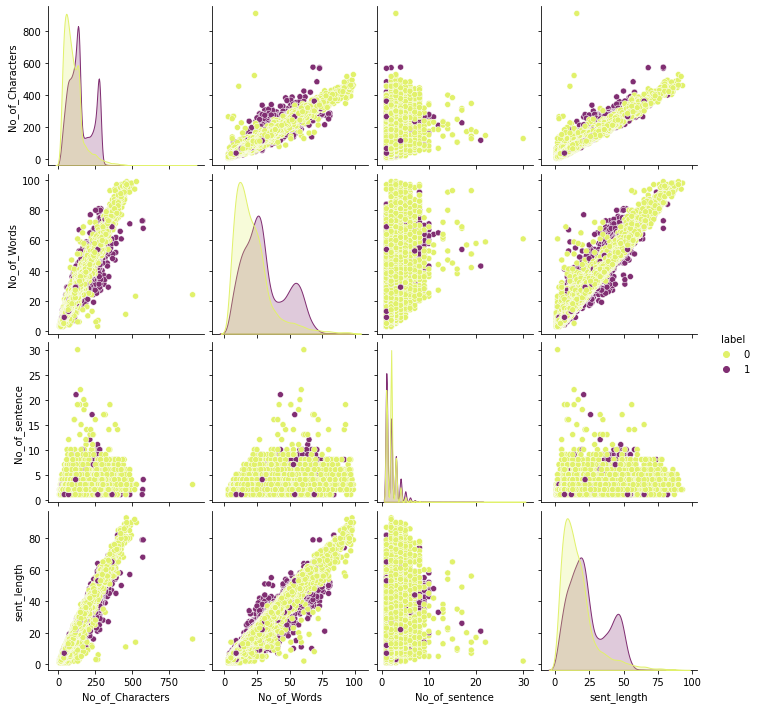

In [ ]:
#Palette
cols= ["#E1F16B", "#802E72"]
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label",palette=cols)
plt.show(fg)